# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>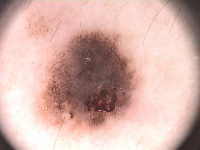</td><td>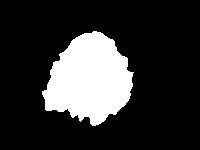</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-06-01 04:04:30--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-06-01 04:04:31--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc87f77200401f0664290f67c9c2.dl.dropboxusercontent.com/cd/0/inline/A4zCu_9DltBklVQXRg5W-yKenjHXMVRSV4i7aIfYvsdnDdVOvFcxwFbOso-PH6eWH_SE3-UTXzSeUcKfD-D0vUa0HvRcLkGM2QnkfurveATnNA/file# [following]
--2020-06-01 04:04:31--  https://uc87f77200401f0664290f67c9c2.dl.dropboxusercontent.com/cd/0/inline/A4zCu_9DltBklVQXRg5W-yKenjHXMVRSV4i7aIfYvsdnDdVOvFcxwFbOso-PH6eWH_SE3-UTXzSeUcKfD-D0vUa0HvRcLkGM2QnkfurveATnNA/file
Resolving 

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

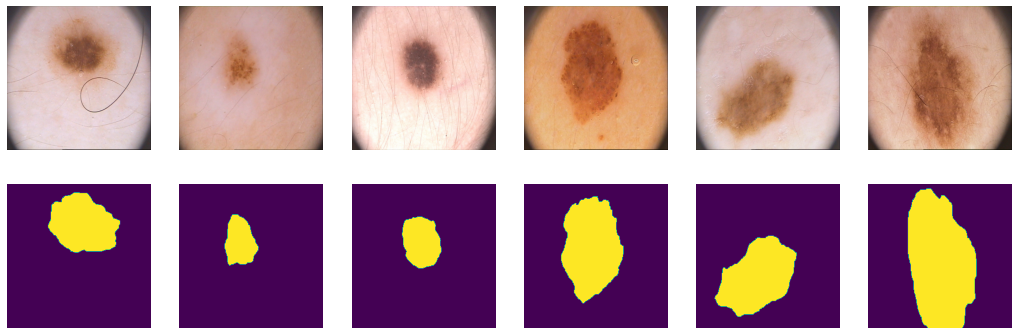

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
seed = 42
np.random.seed(seed)

ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

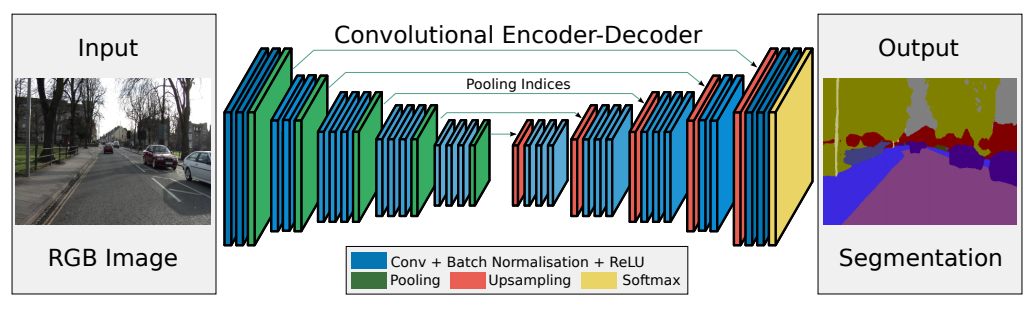

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)
        self.norm_0 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2)  # 256 -> 128

        self.enc_conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
        self.norm_1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64

        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)
        self.norm_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32

        self.enc_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1)
        self.norm_3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.norm = nn.BatchNorm2d(256)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True) # 16 -> 32
        self.dec_conv0 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding = 1)
        self.dec_norm_0 = nn.BatchNorm2d(128)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True) # 32 -> 64
        self.dec_conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding = 1)
        self.dec_norm_1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True)  # 64 -> 128
        self.dec_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding = 1)
        self.dec_norm_2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True) # 128 -> 256
        self.dec_conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, padding = 1)
        self.dec_norm_3 = nn.BatchNorm2d(1)


    def forward(self, x):

        e0 = self.pool0(self.norm_0(F.relu(self.enc_conv0(x))))
        e1 = self.pool1(self.norm_1(F.relu(self.enc_conv1(e0))))
        e2 = self.pool2(self.norm_2(F.relu(self.enc_conv2(e1))))
        e3 = self.pool3(self.norm_3(F.relu(self.enc_conv3(e2))))

        # bottleneck
        b = self.norm(F.relu(self.bottleneck_conv(e3)))

        # decoder
        d0 = self.dec_norm_0(F.relu(self.dec_conv0(self.upsample0(b))))
        d1 = self.dec_norm_1(F.relu(self.dec_conv1(self.upsample1(d0))))
        d2 = self.dec_norm_2(F.relu(self.dec_conv2(self.upsample2(d1))))
        d3 = self.dec_norm_3(F.relu(self.dec_conv3(self.upsample3(d2))))
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    #print(labels.shape, outputs.shape)
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    y_pred = torch.sigmoid(y_pred)
    bce = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    #return torch.mean(bce.sum((1, 2, 3)))
    return bce.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, data_ts, metric):
    X_val, Y_val = next(iter(data_val))
    Y_val = Y_val.to(device)

    test_losses = []
    train_losses = []
    val_losses = []
    test_scores = []
    val_scores = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        epoch_train_losses = []
        epoch_val_losses = []
        epoch_test_losses = []
        test_epoch_scores = []
        val_epoch_scores = []
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            epoch_train_losses.append(loss)
        #train_losses.append(np.mean(epoch_train_losses))
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad(): 
          Y_hat = model(X_val.to(device)).cpu().detach().numpy() > 0.5 # detach and put into cpu

          for X_batch, Y_label in data_val:
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)

            Y_pred = model(X_batch)
            epoch_val_losses.append(loss_fn(Y_pred, Y_label).item())
            val_epoch_scores.append(metric(Y_pred > 0.5, Y_label).mean().item())

          for X_batch, Y_label in data_ts:
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)

            Y_pred = model(X_batch)
            epoch_test_losses.append(loss_fn(Y_pred, Y_label).item())
            test_epoch_scores.append(metric(Y_pred > 0.5, Y_label).mean().item())

        val_losses.append(np.mean(epoch_val_losses))
        test_losses.append(np.mean(epoch_test_losses))
        test_scores.append(np.mean(test_epoch_scores))
        val_scores.append(np.mean(val_epoch_scores))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    
    return val_losses, test_losses, val_scores, test_scores

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ model(X_batch.to(device)) for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device)) > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data) 

## Основной момент: обучение

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

segnet_bce = SegNet().to(device)

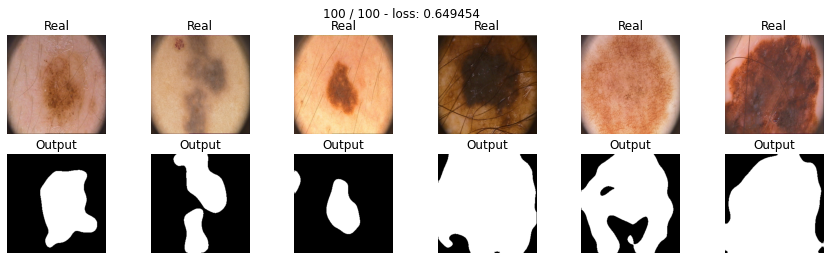

In [ ]:
max_epochs = 100
learning_rate = 1e-3
loss = nn.BCELoss()
optim = torch.optim.Adam(segnet_bce.parameters(), lr = learning_rate)
segnet_bce_val_losses, segnet_bce_test_losses, segnet_bce_val_scores, segnet_bce_test_scores = train(segnet_bce, optim, bce_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
segnet_bce_score = score_model(segnet_bce, iou_pytorch, data_val)
segnet_bce_score

0.7399999499320984

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num = torch.sum((2 * y_pred * y_real))
    den = torch.sum((y_pred + y_real))
    res = 1 - torch.mean((num + 1) / (den + 1)) / (256 * 256)
    return res

Проводим тестирование:

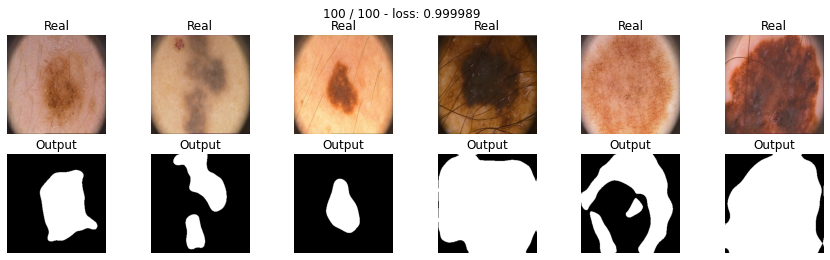

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

segnet_dice = SegNet().to(device)

max_epochs = 100
optimaizer = torch.optim.Adam(segnet_dice.parameters())
segnet_dice_val_losses, segnet_dice_test_losses, segnet_dice_val_scores, segnet_dice_test_scores = train(segnet_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
segnet_dice_score = score_model(segnet_dice, iou_pytorch, data_val)
segnet_dice_score

0.7339999377727509

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    your_loss = torch.mean(((1 - torch.sigmoid(y_pred))**2) * (y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred))))
    return -your_loss

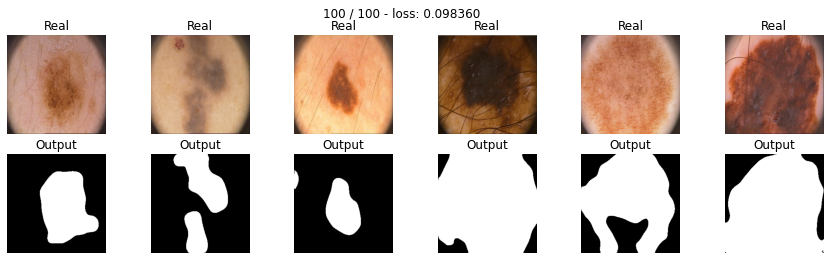

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

segnet_focal = SegNet().to(device)

max_epochs = 100
optimaizer = torch.optim.Adam(segnet_focal.parameters())
segnet_focal_val_losses, segnet_focal_test_losses, segnet_focal_val_scores, segnet_focal_test_scores = train(segnet_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
segnet_focal_score = score_model(segnet_focal, iou_pytorch, data_val)
segnet_focal_score

0.7479999661445618

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [ ]:
def tversky_loss(y_true, y_pred):
  y_pred = torch.sigmoid(y_pred)
  axes = tuple(range(1, len(y_pred.shape) - 1))
  num = torch.sum(y_pred * y_true)
  den = torch.sum(y_true * y_pred + 0.5 * (1 - y_true) * y_pred + 0.5 * y_true * (1 - y_pred))
  return 1 - torch.mean((num + 1e-6) / (den + 1e-6))

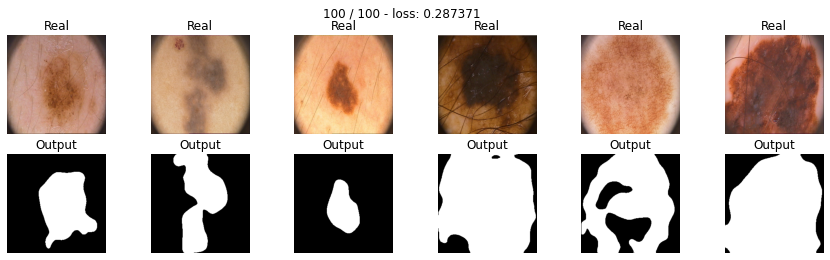

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

segnet_tversky = SegNet().to(device)

max_epochs = 100
optimaizer = torch.optim.Adam(segnet_tversky.parameters())
segnet_tversky_val_losses, segnet_tversky_test_losses, segnet_tversky_val_scores, segnet_tversky_test_scores = train(segnet_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
segnet_tversky_score = score_model(segnet_tversky, iou_pytorch, data_val)
segnet_tversky_score

0.7480000257492065

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

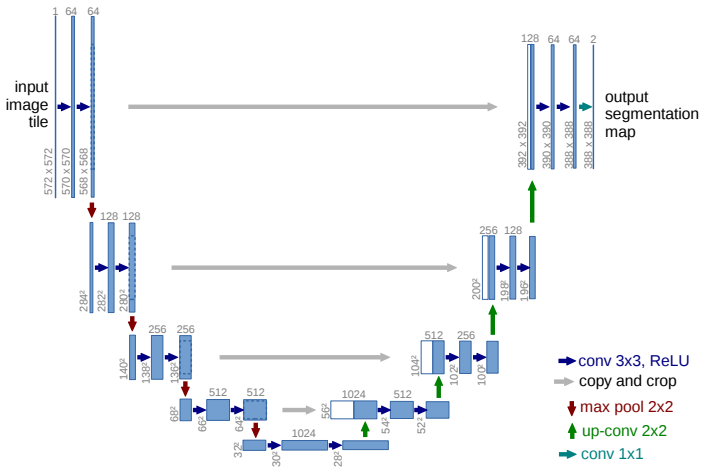

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)
        self.norm_0 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2)  # 256 -> 128

        self.enc_conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
        self.norm_1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64

        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)
        self.norm_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32

        self.enc_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1)
        self.norm_3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding = 1)
        self.dec_norm_0 = nn.BatchNorm2d(256)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=384, out_channels=192, kernel_size=3, padding = 1)
        self.dec_norm_1 = nn.BatchNorm2d(192)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(in_channels=256, out_channels=96, kernel_size=3, padding = 1)
        self.dec_norm_2 = nn.BatchNorm2d(96)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding = 1)
        self.dec_norm_3 = nn.BatchNorm2d(1)

    def forward(self, x):

        # encoder
        e0 = F.relu(self.norm_0(self.enc_conv0(x)))
        e0_pool = self.pool0(e0)
        e1 = F.relu(self.norm_1(self.enc_conv1(e0_pool)))
        e1_pool = self.pool1(e1)
        e2 = F.relu(self.norm_2(self.enc_conv2(e1_pool)))
        e2_pool = self.pool2(e2)
        e3 = F.relu(self.norm_3(self.enc_conv3(e2_pool)))
        e3_pool = self.pool3(e3)
        
        # bottleneck
        b = F.relu(self.bottleneck_conv(e3_pool))

        # decoder
        d0 = F.relu(self.dec_norm_0(self.dec_conv0(torch.cat([e3, self.upsample0(b)], 1))))
        d1 = F.relu(self.dec_norm_1(self.dec_conv1(torch.cat([e2, self.upsample1(d0)], 1))))
        d2 = F.relu(self.dec_norm_2(self.dec_conv2(torch.cat([e1, self.upsample2(d1)], 1))))
        d3 = F.relu(self.dec_norm_3(self.dec_conv3(torch.cat([e0, self.upsample3(d2)], 1))))

        return d3

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

unet_bce = UNet().to(device)

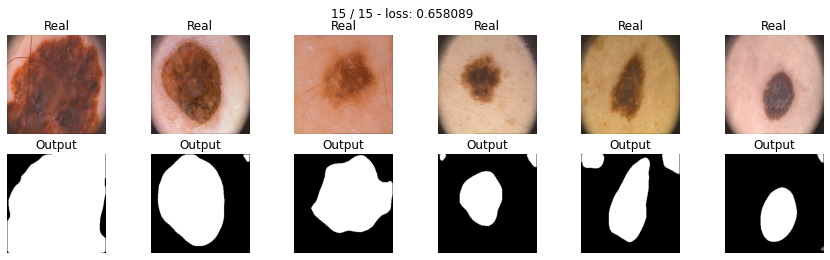

In [ ]:
max_epochs = 15
unet_bce_val_losses, unet_bce_test_losses, unet_bce_val_scores, unet_bce_test_scores = train(unet_bce, torch.optim.Adam(unet_bce.parameters()), bce_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
unet_bce_score = score_model(unet_bce, iou_pytorch, data_val)
unet_bce_score

0.550000011920929

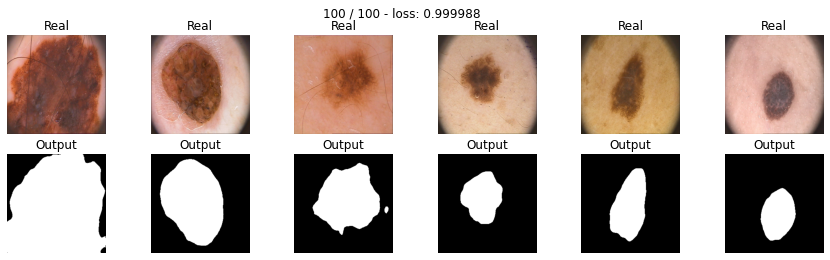

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

unet_dice = UNet().to(device)
unet_dice_val_losses, unet_dice_test_losses, unet_dice_val_scores, unet_dice_test_scores = train(unet_dice, torch.optim.Adam(unet_dice.parameters()), dice_loss, 100, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
unet_dice_score = score_model(unet_dice, iou_pytorch, data_val)
unet_dice_score

0.7560000121593475

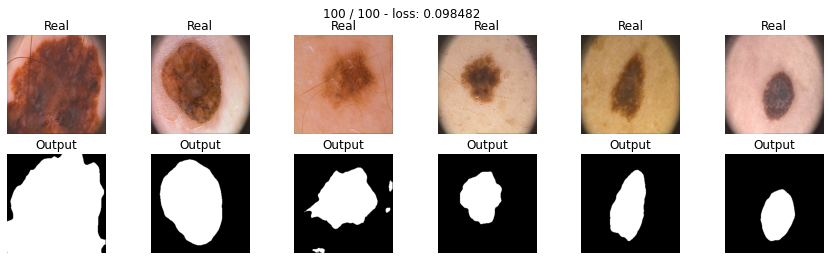

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

unet_focal = UNet().to(device)
unet_focal_val_losses, unet_focal_test_losses, unet_focal_val_scores, unet_focal_test_scores = train(unet_focal, torch.optim.Adam(unet_focal.parameters()), focal_loss, 100, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
unet_focal_score = score_model(unet_focal, iou_pytorch, data_val)
unet_focal_score

0.7459999918937683

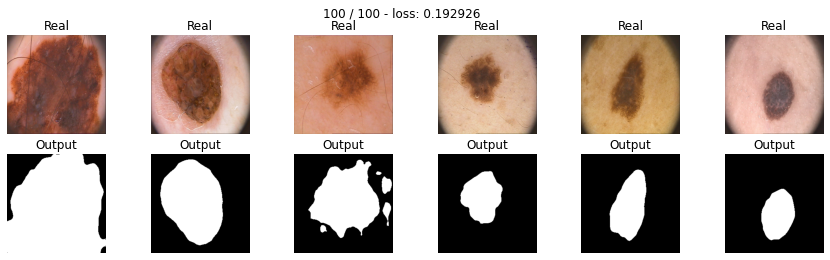

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

unet_tversky = UNet().to(device)
unet_tversky_val_losses, unet_tversky_test_losses, unet_tversky_val_scores, unet_tversky_test_scores = train(unet_tversky, torch.optim.Adam(unet_tversky.parameters()), tversky_loss, 100, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
unet_tversky_score = score_model(unet_tversky, iou_pytorch, data_val)
unet_tversky_score

0.7279999554157257

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)
        self.norm_0 = nn.BatchNorm2d(32)
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1, stride = 2)

        self.enc_conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
        self.norm_1 = nn.BatchNorm2d(64)
        self.pool1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 1, stride = 2)

        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)
        self.norm_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 1, stride = 2)

        self.enc_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1)
        self.norm_3 = nn.BatchNorm2d(256)
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 1, stride = 2)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, padding = 1, stride = 2)
        self.dec_conv0 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding = 1)
        self.dec_norm_0 = nn.BatchNorm2d(384)

        self.upsample1 = nn.ConvTranspose2d(in_channels=384, out_channels=64, kernel_size=4, padding = 1, stride = 2)
        self.dec_conv1 = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding = 1)
        self.dec_norm_1 = nn.BatchNorm2d(192)

        self.upsample2 = nn.ConvTranspose2d(in_channels=192, out_channels=32, kernel_size=4, padding = 1, stride = 2)
        self.dec_conv2 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, padding = 1)
        self.dec_norm_2 = nn.BatchNorm2d(96)

        self.upsample3 = nn.ConvTranspose2d(in_channels=96, out_channels=16, kernel_size=4, padding = 1, stride = 2)
        self.dec_conv3 = nn.Conv2d(in_channels=48, out_channels=1, kernel_size=3, padding = 1)
        self.dec_norm_3 = nn.BatchNorm2d(1)

    def forward(self, x):
        # encoder
        e0 = self.norm_0(F.relu(self.enc_conv0(x)))
        e0_pool = self.pool0(e0)
        e1 = self.norm_1(F.relu(self.enc_conv1(e0_pool)))
        e1_pool = self.pool1(e1)
        e2 = self.norm_2(F.relu(self.enc_conv2(e1_pool)))
        e2_pool = self.pool2(e2)
        e3 = self.norm_3(F.relu(self.enc_conv3(e2_pool)))
        e3_pool = self.pool3(e3)
        
        # bottleneck
        b = F.relu(self.bottleneck_conv(e3_pool))

        # decoder
        d0 = self.dec_norm_0(F.relu(self.dec_conv0(torch.cat([e3, self.upsample0(b)], 1))))
        d1 = self.dec_norm_1(F.relu(self.dec_conv1(torch.cat([e2, self.upsample1(d0)], 1))))
        d2 = self.dec_norm_2(F.relu(self.dec_conv2(torch.cat([e1, self.upsample2(d1)], 1))))
        d3 = self.dec_norm_3(F.relu(self.dec_conv3(torch.cat([e0, self.upsample3(d2)], 1))))

        return d3

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

unet2_bce = UNet2().to(device)

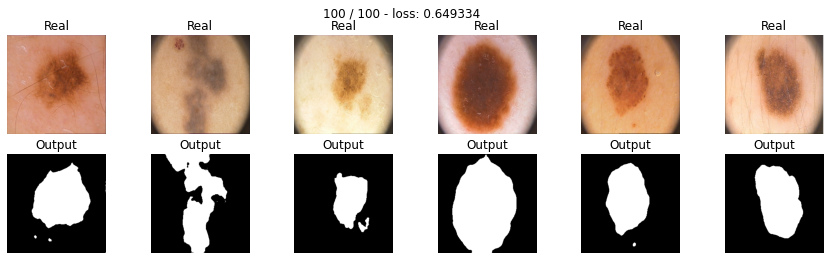

In [ ]:
max_epochs = 100
unet2_bce_val_losses, unet2_bce_test_losses, unet2_bce_val_scores, unet2_bce_test_scores = train(unet2_bce, torch.optim.Adam(unet2_bce.parameters()), bce_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
unet2_bce_score = score_model(unet2_bce, iou_pytorch, data_val)
unet2_bce_score

0.742000013589859

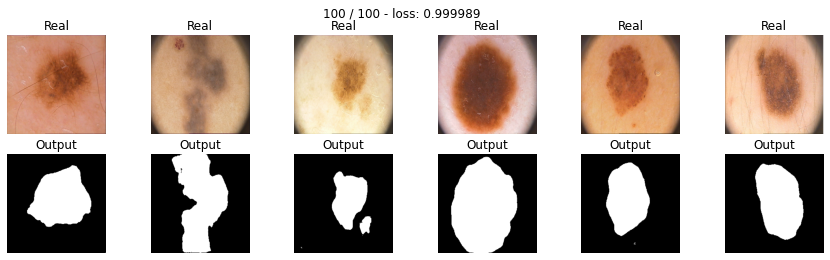

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

unet2_dice = UNet2().to(device)

unet2_dice_val_losses, unet2_dice_test_losses, unet2_dice_val_scores, unet2_dice_test_scores = train(unet2_dice, torch.optim.Adam(unet2_dice.parameters()), dice_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
unet2_dice_score = score_model(unet2_dice, iou_pytorch, data_val)
unet2_dice_score

0.7359999418258667

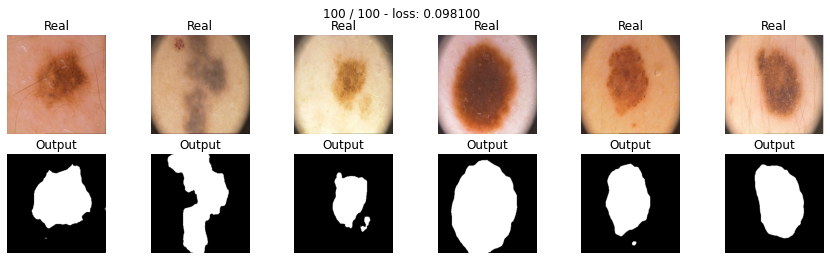

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

unet2_focal = UNet2().to(device)

unet2_focal_val_losses, unet2_focal_test_losses, unet2_focal_val_scores, unet2_focal_test_scores = train(unet2_focal, torch.optim.Adam(unet2_focal.parameters()), focal_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
unet2_focal_score = score_model(unet2_focal, iou_pytorch, data_val)
unet2_focal_score

0.7560000121593475

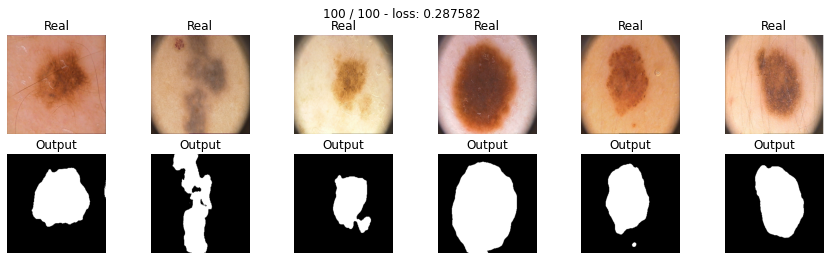

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

unet2_tversky = UNet2().to(device)

unet2_tversky_val_losses, unet2_tversky_test_losses, unet2_tversky_val_scores, unet2_tversky_test_scores = train(unet2_tversky, torch.optim.Adam(unet2_tversky.parameters()), tversky_loss, max_epochs, data_tr, data_val, data_ts, iou_pytorch)

In [ ]:
unet2_tversky_score = score_model(unet2_tversky, iou_pytorch, data_val)
unet2_tversky_score

0.7240000069141388

Сделайте вывод какая из моделей лучше

ВЫВОД

Лучшей из двух моделей (undet_model и unet2_model) оказалась последняя. По отрисовке картинок видно, что она улавливает наиболее мелкие паттерны и изгибы.